In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

In [2]:
# load regional structural measures
CT_data = pd.read_csv('raw_data/ukbb_CT_DK.csv').dropna(how='any')
CSA_data = pd.read_csv('raw_data/ukbb_CSA_DK.csv').dropna(how='any')
sub_data = pd.read_csv('raw_data/ukbb_sub_volumes.csv').dropna(how='any')

In [3]:
# load functional measures
FC_data = pd.read_csv('raw_data/ukbb_FC_data.csv').dropna(how='any')

# load global structural measures
global_data = pd.read_csv('raw_data/global_brain_measures.csv').dropna(how='any')

# load scanning positions x,y,z
pos_data = pd.read_csv('raw_data/scanning_positions.csv').dropna(how='any')

# load covariates 
age_sex = pd.read_csv('raw_data/ukbb_age_sex.csv').dropna(how='any')
cols = ['eid']
for i in range(25):
    cols.append('PC'+str(i+1))
PCs = pd.read_csv('raw_data/top_100_PCs.csv')[cols].dropna(how='any')

# load rsfMRI head motions
motions = pd.read_csv('raw_data/ukbb_rsfMRI_head_motions.csv').dropna(how='any')

# load PRS data
PRS_data = pd.read_csv('raw_data/multi_PRSs.csv').dropna(how='any')

In [4]:
# merge data
CT_data.set_index('eid',inplace=True)
CSA_data.set_index('eid',inplace=True)
sub_data.set_index('eid',inplace=True)
FC_data.set_index('eid',inplace=True)
global_data.set_index('eid',inplace=True)
pos_data.set_index('eid',inplace=True)
age_sex.set_index('eid',inplace=True)
PCs.set_index('eid',inplace=True)
motions.set_index('eid',inplace=True)
PRS_data.set_index('eid',inplace=True)

l = list(set(FC_data.index) & set(motions.index) & set(CT_data.index) & set(CSA_data.index) & set(sub_data.index) \
         & set(global_data.index) & set(pos_data.index) & set(age_sex.index) & set(PCs.index) & set(PRS_data.index))

final_FC = FC_data.loc[l]
final_CT = CT_data.loc[l]
final_CSA = CSA_data.loc[l]
final_sub = sub_data.loc[l]
final_global_measures = global_data.loc[l]
final_pos = pos_data.loc[l]
final_age_sex = age_sex.loc[l]
final_PCs = PCs.loc[l]
final_motions = motions.loc[l]
final_PRSs = PRS_data.loc[l]

final_FC.reset_index(inplace=True)
final_CT.reset_index(inplace=True)
final_CSA.reset_index(inplace=True)
final_sub.reset_index(inplace=True)
final_global_measures.reset_index(inplace=True)
final_pos.reset_index(inplace=True)
final_age_sex.reset_index(inplace=True)
final_PCs.reset_index(inplace=True)
final_motions.reset_index(inplace=True)
final_PRSs.reset_index(inplace=True)

In [5]:
PCs_25 = final_PCs.iloc[:,1:].values
age = final_age_sex.iloc[:,2:3].values
sex = final_age_sex.iloc[:,1:2].values
postions = final_pos.iloc[:,1:].values
head_motion = final_motions.iloc[:,1:2].values
sex = sex + 1

co = np.hstack((PCs_25,age,sex,age*age,age*sex,age*age*sex,postions,head_motion))

In [6]:
# function used for regressing out the effects of covariates 
from sklearn.preprocessing import StandardScaler

def regression_covariant(covariant_matrix, y, standard_scale=False):
    a = np.hstack((covariant_matrix,np.ones((covariant_matrix.shape[0], 1))))
    w = np.linalg.lstsq(a,y,rcond=None)[0]

    residual = y - covariant_matrix.dot(w[:-1])
    residual = residual.astype('float64')

    if standard_scale:
        residual = StandardScaler().fit_transform(residual.reshape(-1,1)).flatten()

    return residual, w

In [7]:
#regressing out the effects of covariates for X and Y
X = final_PRSs.iloc[:,1:].values
X[:,7] = -X[:,7]
X[:,8] = -X[:,8]
X[:,11] = -X[:,11]

Y_CT = final_CT.iloc[:,1:].values
Y_CSA = final_CSA.iloc[:,1:].values
Y_sub = final_sub.iloc[:,1:].values
Y_FC = final_FC.iloc[:,1:].values
Y = np.hstack((Y_CSA,Y_CT,Y_sub,Y_FC))

rX = np.empty(X.shape)
rY = np.empty(Y.shape)

for i in range(X.shape[1]):
    [rx, w] = regression_covariant(co,X[:,i],standard_scale=True)
    rX[:,i] = rx
    
for i in range(Y.shape[1]):
    [ry, w] = regression_covariant(co,Y[:,i],standard_scale=True)
    rY[:,i] = ry

In [9]:
# do permuation test (n=1000)
# randomly sort the X and run PLS analysis for 1000 times
import warnings
from sklearn.cross_decomposition import PLSCanonical, CCA
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
n_perm = 1000
ncom = 2
sub_num = int(0.5*rX.shape[0])
n_times = 100

selected_num = np.zeros((X.shape[1],ncom,n_perm))
selected_sum = np.zeros((X.shape[1],ncom,n_perm))
imaging_num = np.zeros((Y.shape[1],ncom,n_perm))
imaging_sum = np.zeros((Y.shape[1],ncom,n_perm))

for q in range(n_perm):
    print(q)
    # shuffle rX
    order = np.random.permutation(rX.shape[0])
    mrX = rX[order]
    # stable selecture
    for t in range(n_times):
#         print(t)
        #split data
        order = np.random.permutation(rX.shape[0])
        trX = mrX[order]
        trY = rY[order]
        sub1_X = trX[:sub_num,:]
        sub1_Y = trY[:sub_num,:]
        sub2_X = trX[sub_num:,:]
        sub2_Y = trY[sub_num:,:]
        # group 1
        plsca = PLSCanonical(n_components=ncom)
        plsca.fit(sub1_X, sub1_Y)
        X_c1, Y_c1 = plsca.transform(sub1_X, sub1_Y)
        X_w1 = plsca.x_weights_
        Y_w1 = plsca.y_weights_

        # group 2
        plsca = PLSCanonical(n_components=ncom)
        plsca.fit(sub2_X, sub2_Y)
        X_c2, Y_c2 = plsca.transform(sub2_X, sub2_Y)
        X_w2 = plsca.x_weights_
        Y_w2 = plsca.y_weights_    

        # selection of relavant PRSs
        for i in range(ncom):
            x1 = X_w1[:,i]
            x2 = X_w2[:,i]
            order1 = list(np.argsort(-abs(x1)))
            order2 = list(np.argsort(-abs(x2)))
            f = list(set(order1[:5]) & set(order2[:5]))
#             for u in f:
            selected_num[f,i,q] = selected_num[f,i,q] + 1

            selected_sum[:,i,q] = selected_sum[:,i,q] + (x1+x2)/2

            y1 = Y_w1[:,i]
            y2 = Y_w2[:,i]
            order3 = list(np.argsort(-abs(y1)))
            order4 = list(np.argsort(-abs(y2)))
            t1 = int(0.1*Y.shape[1])
            f2 = list(set(order3[:t1]) & set(order4[:t1]))
#             for u in f2:
            imaging_num[f2,i,q] = imaging_num[f2,i,q] + 1
            imaging_sum[:,i,q] = imaging_sum[:,i,q] + (y1+y2)/2

In [10]:
# save permuation test results
np.save('results/permutation/selected_num_perm.npy',selected_num)
np.save('results/permutation/selected_sum_perm.npy',selected_sum)
np.save('results/permutation/imaging_num_perm.npy',imaging_num)
np.save('results/permutation/imaging_sum_perm.npy',imaging_sum)

In [11]:
# load permuation test results
imaging_num = np.load('results/permutation/imaging_num_perm.npy')/100
selected_num = np.load('results/permutation/selected_num_perm.npy')/100
imaging_sum = np.load('results/permutation/imaging_sum_perm.npy')/100
selected_sum = np.load('results/permutation/selected_sum_perm.npy')/100

In [13]:
#load true PLS results
intermediate_dataX = np.load('results/PLS_results/intermediate_dataX.npy')
intermediate_dataY = np.load('results/PLS_results/intermediate_dataY.npy')

In [14]:
PRS_names = ['ADHD', 'Alzheimer\'s disorder', 'ASD', 'Bipolar disorder', 'Eating disorder',
       'Major depression', 'Schizophrenia', 'Cigarettes per day', 'Smoking initiation',
       'Smoking cessation', 'Caffeine consumption', 'Alcoholic drinks per week',
       'Cognitive ability', 'Educational attainment']

In [15]:
import matplotlib.pyplot as plt
def plot_x_weights(data,PRS_names,output_file):
    for component in range(data.shape[1]):
        titles = ['The first genotype component','The second genotype component']
        fig = plt.figure(figsize = (12,6))
        ss = data

        ax = plt.plot(np.arange(ss.shape[0]), ss[:,component], color='green', marker='o', linestyle='-',linewidth=4, markersize=12)
        plt.title(titles[component],fontsize=20)
        plt.ylabel('P values',fontsize=20)
        plt.ylim((0,1.05))
        my_path = output_file + 'permuation_C'+str(component+1)+'.png'
        
        plt.xticks(np.arange(ss.shape[0]),PRS_names,horizontalalignment='right',rotation=30)
        plt.tick_params(labelsize=15)
        fig.savefig(my_path,dpi=300,bbox_inches = 'tight')
    return

In [16]:
size_X = intermediate_dataX.shape
n_times = 5000
ncom = 2
x_t = 5
true_selected_num = np.zeros((size_X[0],ncom))
true_selected_sum = np.zeros((size_X[0],ncom))

for t in range(n_times):
    W1 = intermediate_dataX[:,:,t,0]
    W2 = intermediate_dataX[:,:,t,1]
    for i in range(ncom):
        x1 = W1[:,i]
        x2 = W2[:,i]
        order1 = list(np.argsort(-abs(x1)))
        order2 = list(np.argsort(-abs(x2)))
        f = list(set(order1[:x_t]) & set(order2[:x_t]))
        for u in f:
            true_selected_num[u,i] = true_selected_num[u,i] + 1
 
        true_selected_sum[:,i] = true_selected_sum[:,i] + (x1+x2)/2

In [17]:
size_Y = intermediate_dataY.shape
n_times = 5000
ncom = 2
y_t = 0.1
true_imaging_num = np.zeros((size_Y[0],ncom))
true_imaging_sum = np.zeros((size_Y[0],ncom))
y_t_num = int(y_t*size_Y[0])
for t in range(n_times):
    W1 = intermediate_dataY[:,:,t,0]
    W2 = intermediate_dataY[:,:,t,1]
    for i in range(ncom):
        x1 = W1[:,i]
        x2 = W2[:,i]
        order1 = list(np.argsort(-abs(x1)))
        order2 = list(np.argsort(-abs(x2)))
        f = list(set(order1[:y_t_num]) & set(order2[:y_t_num]))
        for u in f:
            true_imaging_num[u,i] = true_imaging_num[u,i] + 1
 
        true_imaging_sum[:,i] = true_imaging_sum[:,i] + (x1+x2)/2

In [18]:
true_selected_num = true_selected_num/n_times
true_imaging_num = true_imaging_num/n_times

true_selected_sum = true_selected_sum/n_times
true_imaging_sum = true_imaging_sum/n_times

In [19]:
#calculate permuation p values
def calculate_p_Values(true_data,perm_data):
    
    s = perm_data.shape
    p_values = np.zeros((s[0],s[1]))
    for i in range(s[0]):
        tmp_data1 = perm_data[i,0,:]
        tmp_data2 = perm_data[i,1,:]

        true_probability_PC1 = true_data[i,0]
        true_probability_PC2 = true_data[i,1]

        p_values[i,0] = 1 - float(np.sum(tmp_data1 < true_probability_PC1)/s[2])
        p_values[i,1] = 1 - float(np.sum(tmp_data2 < true_probability_PC2)/s[2])
        
    return p_values

In [20]:
PGSs_p_values1 = calculate_p_Values(true_selected_num,selected_num)
imaging_p_values1 = calculate_p_Values(true_imaging_num,imaging_num)

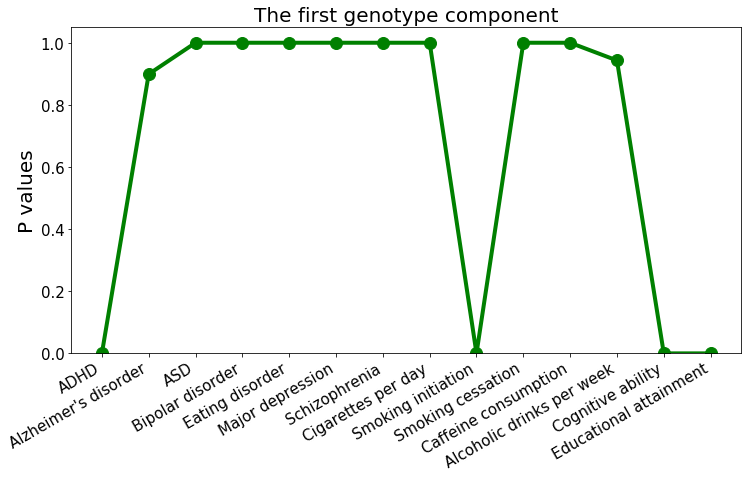

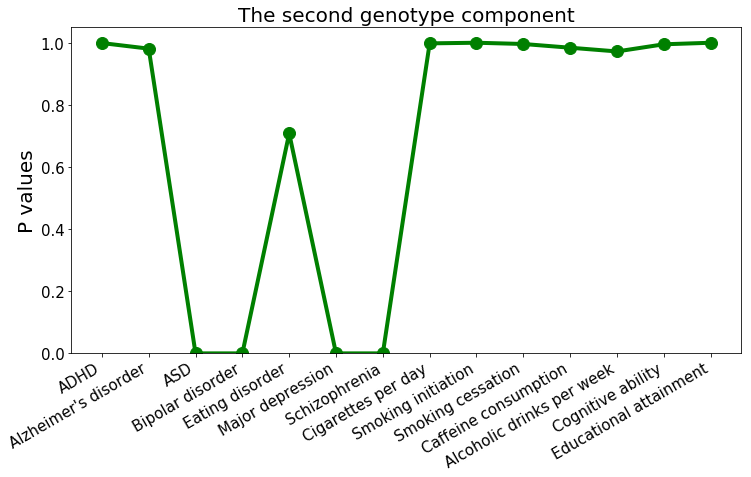

In [21]:
plot_x_weights(PGSs_p_values1,PRS_names,'results/permutation/')

In [ ]:
column_names = pd.read_csv('results/PLS_results_other_parameters/regions.txt').iloc[:,0].values
wdata = pd.DataFrame(data=column_names,columns=['features'])
for i in range(ncom):
    ss = 'weights'+str(i+1)
    wdata[ss] = imaging_p_values1[:,i]
wdata.to_csv('results/permutation/imaging_permutaion_p_values.csv',index=False)